# **Statistical Arbitrage - Pairs trading strategy**

# Dependencies

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade statsmodels

In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.rolling import RollingOLS
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import datetime as dt
import seaborn as sns

# Theory summary

**Cointegration**

Consider two $I(1)$ time series $X_{1,t}$ and $X_{2,t}$, if there exists a $β$ such that $X_{2,t}-\beta X_{1,t}=y_t$, where $y_t$ is a stationary series ($I(0)$) then $ X_{1,t}$ and  $X_{2,t}$ are cointegrated.

We can estimate this $β$ using ordinary least squares regression applied to the following model:

$X_{2,t}=\alpha + \beta X_{1,t} +ϵ$

Essentially we are trying to remove $X_2$'s dependency on $X_1$ and as such we are left with stationary noise through $X_{2,t}-\beta X_{1,t}$. This is what we will refer to as our spread. Due to the stationary nature of the spread it will exhibit mean reversion and it is this property that is at the crux of pairs trading strategies.

Define $K_t=X_{2,t}-\beta X_{1,t}$ as the spread at time $t$. So if we buy 1 share of $X_2$ and sell short $\beta$ shares of $X_1$ at time $t$, then our P&L over 2 consecutive periods of holding the spread will be:

$K_t-K_{t-1}=(X_{2,t}-\beta X_{1,t})-(X_{2,t-1}-\beta X_{1,t-1})$

We know the spread has mean reverting properties and so if the spread at a given time has a value that is much higher than the long term equilibrium then we short the spread and vice versa. This is the underlying concept for a cointegration based trading strategy and this notebook will explore such a strategy


---

**Tests for cointegration and stationarity**

This notebook uses the Engle-Granger two step method which tests for cointegration between a pair of securities and estimates $\beta$ using OLS. 
We also explore explicity the Dickey-Fuller test for stationarity for completeness. The coint function in the statsmodels module allows us to carry out the Engle-Granger two step method directly.

The basis of this strategy and cointegration testing procedure builds on work done by [1].



# Finding pairs of cointegrated stocks

A good first step in finding cointegrated stocks is to choose stocks that we have some intuituve belief may be cointegrated. This may be because they belong to the same sector or something else more nuanced. For simplicity I have chosen big tech based stocks in the S&P500 for rudimentary testing of the concept behind cointegration based pairs trading strategies.

In [ ]:
end=dt.datetime.now()
start=dt.datetime(2015,1,1)
stocks=['AAPL', 'MSFT', 'GOOGL', 'META', 'AMD', 'INTC', 'IBM', 'EBAY', 'AMZN'] # Couple of big tech stocks which we might expect a cointegration between

In [ ]:
df=pdr.DataReader(stocks, data_source='yahoo', start=start, end=end)['Adj Close']
df.head()

Symbols,AAPL,MSFT,GOOGL,META,AMD,INTC,IBM,EBAY,AMZN
Date,,,,,,,,,
2015-01-02,24.644018,41.013317,26.477501,78.449997,2.67,29.320631,112.178093,22.526384,15.4260
2015-01-05,23.949753,40.636169,25.973000,77.190002,2.66,28.990000,110.412979,22.338026,15.1095
2015-01-06,23.952013,40.039734,25.332001,76.150002,2.63,28.449717,108.031815,22.049484,14.7645
2015-01-07,24.287868,40.548454,25.257500,76.150002,2.58,29.046448,107.325745,22.013414,14.9210
2015-01-08,25.221062,41.741306,25.345501,78.180000,2.61,29.586733,109.658470,22.606531,15.0230


In [ ]:
split=0.7
mark=int(split*df.shape[0])
train_df=df[:mark]
test_df=df[mark:]

The following function checks every pair of stocks and applies the Engler-Granger method to check for cointegration.

**Dickey-Fuller test**

This is the test used in our implemetation of the Engle-Granger method that tests for a unit root of a time series. With the null hypothesis being the series is not stationary and so in order to gain enough evidence to reject the null hypothesis we look for small p values. The smaller the p value for the spread of a given pair the smaller the chance of a false negative and the more confident we can be of cointegration of the securities.

In [ ]:
def cointegration_pairs(df):
  stocks_no=df.shape[1]
  corrs=np.zeros((stocks_no, stocks_no))
  p_values=np.zeros((stocks_no, stocks_no))
  stcks=df.keys()
  correlated_stocks=[]
  for i in range(stocks_no):
    for j in range(i+1, stocks_no):
      a=df[stcks[i]]
      b=df[stcks[j]]
      corr, pvalue, _ = coint(a,b)
      corrs[i,j]=corr
      p_values[i,j]=pvalue
      if pvalue < 0.05: # significance level for cointegration, null hypothesis is that no cointegration
          correlated_stocks.append([stcks[i],stcks[j]])
  return corrs, p_values, correlated_stocks


[['GOOGL', 'INTC'], ['META', 'EBAY'], ['INTC', 'AMZN'], ['IBM', 'EBAY'], ['IBM', 'AMZN']]


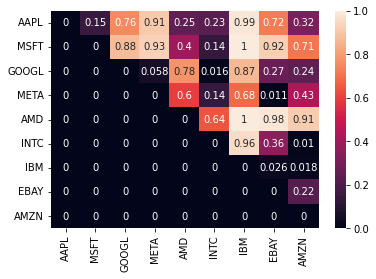

In [ ]:
corrs, p_values, correlated_stocks = cointegration_pairs(train_df)
sns.heatmap(p_values, xticklabels=stocks, yticklabels=stocks, annot=True)
print(correlated_stocks)

From the above p values it seems that the most likely cointegrated pairs are (AMZN,INTC), (GOOGL, INTC) and (EBAY, META) with false negative probabilities around 1%. We choose META and EBAY for the rest of the analysis in the notebook for a cointegration based pair trading strategy

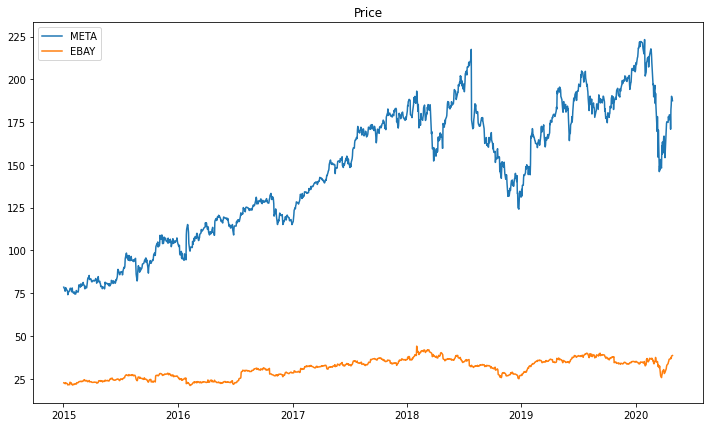

In [ ]:
A=train_df['META']
B=train_df['EBAY']
plt.figure(figsize=(12,7))
plt.plot(A, label='META')
plt.plot(B, label='EBAY')
plt.title('Stock prices')
plt.title('Price')
plt.legend()

Having picked out our cointegrated pair of securities we explicitly go through the process of the Engle-Granger method for completeness. First using OLS to find $\beta$ for the spread and then applying the Augmented Dickey-Fuller test to test for stationarity of the spread. Augkmented Dickey-Fuller is an extension of tradiitonal Dickey-Fuller which removes autocorrelation before carrying out the normal Dickey-Fuller methodology.

In [ ]:
A=sm.add_constant(A)
model=sm.OLS(B,A).fit()
model.params

const    12.985438
META      0.122960
dtype: float64

Note that the following graph has look ahead bias as we are using the whole training dataset to calculate $\beta$. But it does provide a good visualisation of the mean reverting neature of the spread we are tryng to capture in our strategy. This becomes more apparent in the following graphs where we define $Z$ scores.

Text(0.5, 1.0, 'Absolute Spread')

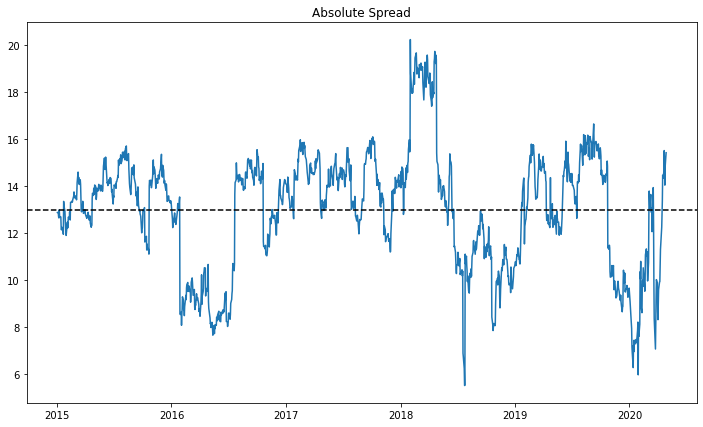

In [ ]:
A=A['META']
hedge=model.params['META']
spread=B-(hedge*A)
plt.figure(figsize=(12,7))
plt.plot(spread)
plt.axhline(spread.mean(), color='black', linestyle='dashed', label='mean')
plt.title('Absolute Spread')

**Normalisation**

We define the $Z$ score as a way to normalise the absolute value of the spread, this will become useul when we begin to implement the trading strategy.

In [ ]:
def z_value(data):
  '''Normalise data to generate signals'''
  return (data-data.mean())/np.std(data)

We can plot the $Z$ values of the spread using a fixed relationship for the cointegrated pair 

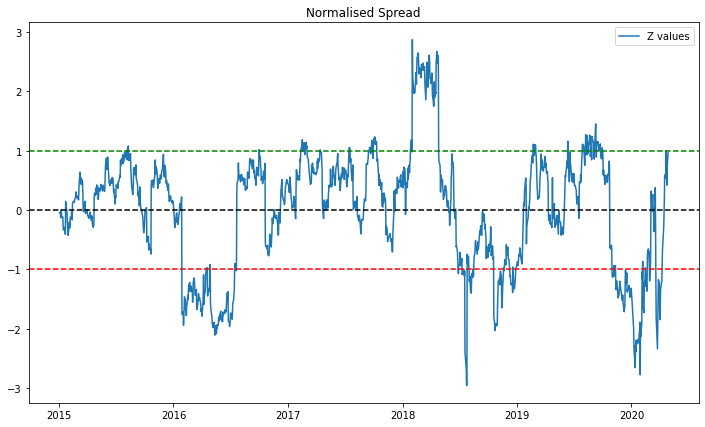

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(z_value(spread), label='Z values')
plt.axhline(1.0, color='green', linestyle='dashed')
plt.axhline(-1.0, color='red', linestyle='dashed')
plt.axhline(0.0, color='black', linestyle='dashed')
plt.title('Normalised Spread')
plt.legend()

**Augmented Dickey-Fuller**

We apply the Augmented Dickey Fuller test explicitly for completeness to show if we have sufficient evidence to suggest that the linear combination (the spread) constructed is stationary.

In [ ]:
adf=adfuller(spread)
print('P value is: ', adf[1]) #If this is less than like 0.05 (significance level) then we have reason to believe stationarity


P value is:  0.0016695617859134317


So this is significant and the series is likely stationary and we have evidence to reject the null hypothesis.

# Implementing an intial cointegration based strategy

We now implement an initial strategy using the long term $β$ constant for the hedge. We cannot test this strategy on the training data as we would be incorporating look ahead bias as we used the training data to calculate $β$ itself and so we backtest the strategy on the testing data. As a rudimentary test to check whether we would expect our strategy to work, we can apply the Dickey-Fuller test to the test data with the long term $β$ calculated from the training data to check for stationarity of the spread. If we get a small p value we have reason to believe that this strategy has a foundation to work.

In [ ]:
A_test=test_df['META']
B_test=test_df['EBAY']
A_test

Date
2020-04-28    182.910004
2020-04-29    194.190002
2020-04-30    204.710007
2020-05-01    202.270004
2020-05-04    205.259995
                 ...    
2022-08-01    159.929993
2022-08-02    160.190002
2022-08-03    168.800003
2022-08-04    170.570007
2022-08-05    167.110001
Name: META, Length: 574, dtype: float64

In [ ]:
spread_test=B_test-(hedge*A_test)#['META']) # Using the hedge or the long term beta we calculated from the previous data
adf2=adfuller(spread_test)
print('P value is: ', adf2[1])

P value is:  0.021082074687660275


We obtain a small p value and so have evidence to believe that the spread remains to be cointegrated in the future.

In [ ]:
Z_test_scores=(spread_test-spread.mean())/spread.std() # Using the long term mean from the testing period before had the short term one
Z_test_scores

Date
2020-04-28    0.978043
2020-04-29    0.409828
2020-04-30    0.205298
2020-05-01    0.101134
2020-05-04    0.178530
                ...   
2022-08-01    6.447749
2022-08-02    6.233227
2022-08-03    6.625609
2022-08-04    5.506372
2022-08-05    5.441237
Length: 574, dtype: float64

**Equity curves and returns**

Calculating returns from pairs trading strategies is slightly nuanced and so we employ a daily P&L approach to plot equity curves. This is a simple way of checking the profitability of a strategy and for a further explanation refer to https://hudsonthames.org/correct-backtest-methodology-pairs-trading/.

In [ ]:
portfolio_returns=spread_test.diff() # This is the portfolio's daily return
portfolio_returns=portfolio_returns.shift(-1) # I have added this shift for consistentcy as to how we perform P&L calculations later in the notebook
portfolio_returns

Date
2020-04-28   -1.435537
2020-04-29   -0.516725
2020-04-30   -0.263160
2020-05-01    0.195534
2020-05-04    0.253229
                ...   
2022-08-01   -0.541969
2022-08-02    0.991315
2022-08-03   -2.827640
2022-08-04   -0.164558
2022-08-05         NaN
Length: 574, dtype: float64

**Trading Signals**


Now we want to generate trading signals based on the assumed mean reverting property of this cointegrated pair.


*   We want to buy the spread when $Z<-Δ$ as we expect the spread value to go back up to 0.
*   We short the spread when $Z>Δ$ as we expect the spread value to go back down to 0.


*   When the spread returns to close to 0 we close our position in both the stocks. In particular if $|Z|<0.05 $ then we close our current position.



When we enter the spread we buy 1 share of $X_2$ and sell $\beta$ shares of $X_1$. In this notebook we predominately use $\Delta=2$.



In [ ]:
def positions(Z_score, delta, portfolio_returns):
  '''
  Returns all the positions we take at any given day depending on our strategy
  in the form of a pandas series object
  '''
  pos=[]
  for i in range(0, len(Z_score)):
    if Z_score[i]>delta: #Then we sell short the spread
      pos.append(-1)
    elif Z_score[i]<-delta: #Then we buy the spread
      pos.append(1)
    elif abs(Z_score[i])<0.05:
      pos.append(0)
    else:
      if i==0:
        pos.append(0)
      else:
        pos.append(pos[i-1]) # If none of the preceeding conditions are met, the position stays the same as the day before
  positions=pd.Series(data=pos, index=Z_score.index)
  print(positions.shape)
  strat_pnl=portfolio_returns*positions
  final_pnl=strat_pnl.cumsum()
  return final_pnl

(574,)


Text(0.5, 1.0, 'Equity Curve P&L')

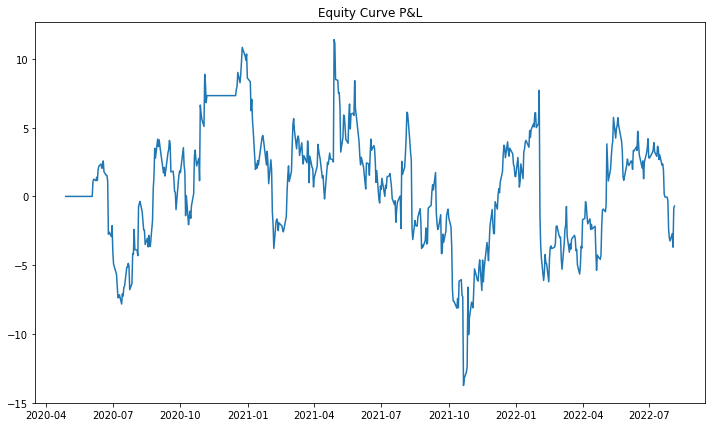

In [ ]:
pnl=positions(Z_test_scores, 2, portfolio_returns) # We use delta=2
plt.figure(figsize=(12,7))
plt.plot(pnl)
plt.title('Equity Curve P&L')

**Results**

Overall this does not seem too promising, the profit and loss seems to average around 0, although over the lifetime of the strategy it is slightly skewed towards the positive end which shows some promise. Having carried out the DF test on the testing time period we had strong reason to believe stationarity, but the strategy in this case has not performed as well as we would have expected it to. Naturally finding a pair of securities with higher cointegration that extends into the future will generate greater returns. 

In [ ]:
pnl.mean() # This is slightly higher than 0 which suggests that our trades on average make money

0.6886583381045949

#Rolling statistics framework strategy
If we have reason to believe that stocks are cointegrated, an approach we can use is to employ rolling statistics to make decisions to buy the spread or not.
We will work with the spread, at each time updating the beta parameters for the spread (adjusting the linear relationship depending on data from the past) and then calculate a normalised $Z$ score.

 $Z=(K_t( \beta_t )-\overline{K_t(\beta_t)})/\sigma_K$

Where $\sigma_k$ is the standard deviation of the spread over $n$ days in the past.
Note that here the spread at time $t$ depends on $\beta_t$ which is calculated on a rolling window on $n$ days in the past. We use $n=60$ in this notebook but this can easily be changed. Essentially the spread relationship changes with time, at any given time use OLS of the past $n$ days to calculate $\beta$ of today. We then use this spread value and compare it to the average value of the spread over a given number of days in the past (also 60 in this notebook) and calculate the $Z$ score.

In [ ]:
windowsize=60

We initially apply this rolling window approach to the training dataset, since we are constantly calculating $\beta_t$ based on data of the past to create our spread we do not have any explicit look ahead bias.

In [ ]:
A=train_df['META']
A=sm.add_constant(A)
rols=RollingOLS(B, A, window=windowsize).fit() # Using a window of windowsize days to calculate beta
params=rols.params['META']
params.dropna(inplace=True)
params

Date
2015-03-30    0.220206
2015-03-31    0.216405
2015-04-01    0.212335
2015-04-02    0.207613
2015-04-06    0.200219
                ...   
2020-04-21    0.098735
2020-04-22    0.100677
2020-04-23    0.103050
2020-04-24    0.110126
2020-04-27    0.113580
Name: META, Length: 1279, dtype: float64

The spread now consists of a changing hedge, due to the changing $\beta$, as such the trader has to constantly update his spread.

In [ ]:
spread_rolling=B-(params*A['META'])
spread_rolling.dropna(inplace=True)
spread_rolling

Date
2015-03-30     4.894506
2015-03-31     5.322663
2015-04-01     5.553654
2015-04-02     5.873957
2015-04-06     6.264774
                ...    
2020-04-21    19.655673
2020-04-22    18.789653
2020-04-23    17.733235
2020-04-24    17.277570
2020-04-27    17.184767
Length: 1279, dtype: float64

Text(0.5, 1.0, 'Absolute spread value using rolling window over training set')

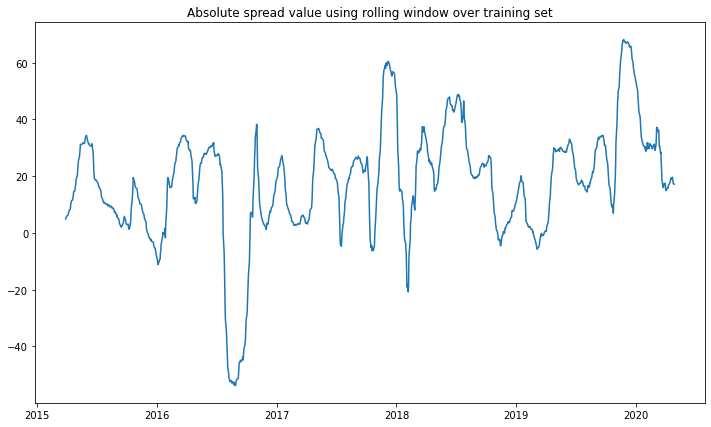

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(spread_rolling.index, spread_rolling.values)
plt.title('Absolute spread value using rolling window over training set')

In [ ]:
avg_spread=spread_rolling.rolling(window=windowsize).mean()
avg_std=spread_rolling.rolling(window=windowsize).std()
avg_spread.dropna(inplace=True)
avg_std.dropna(inplace=True)
avg_spread

Date
2015-06-23    22.196290
2015-06-24    22.469912
2015-06-25    22.712045
2015-06-26    22.936196
2015-06-29    23.150031
                ...    
2020-04-21    25.876662
2020-04-22    25.683105
2020-04-23    25.471951
2020-04-24    25.267837
2020-04-27    25.049016
Length: 1220, dtype: float64

We only need the daily spread value from dates onwards as to where we can define the average spread

In [ ]:
spread_rolling=spread_rolling[windowsize-1:]
spread_rolling

Date
2015-06-23    24.117335
2015-06-24    21.311831
2015-06-25    19.850661
2015-06-26    19.002704
2015-06-29    18.704026
                ...    
2020-04-21    19.655673
2020-04-22    18.789653
2020-04-23    17.733235
2020-04-24    17.277570
2020-04-27    17.184767
Length: 1220, dtype: float64

Text(0.5, 1.0, 'Rolling Z value of spread based on past data')

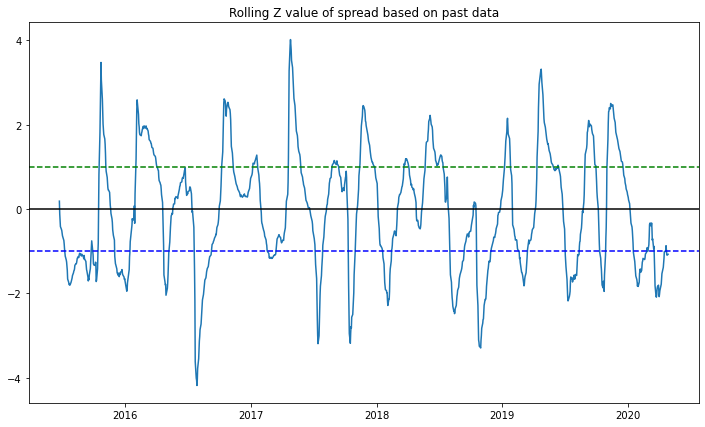

In [ ]:
Z_score_rolling=(spread_rolling-avg_spread)/avg_std
plt.figure(figsize=(12,7))
plt.plot(Z_score_rolling)
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='dashed') # Line to show possible delta we can use and so when we enter trades
plt.axhline(-1.0, color='blue', linestyle='dashed')
plt.title('Rolling Z value of spread based on past data')

In [ ]:
rolling_returns=spread_rolling.diff()
rolling_returns=rolling_returns.shift(-1)
rolling_returns

Date
2015-06-23   -2.805504
2015-06-24   -1.461170
2015-06-25   -0.847957
2015-06-26   -0.298677
2015-06-29    0.058975
                ...   
2020-04-21   -0.866020
2020-04-22   -1.056418
2020-04-23   -0.455665
2020-04-24   -0.092803
2020-04-27         NaN
Length: 1220, dtype: float64

(1220,)


Text(0.5, 1.0, 'P&L Equity curve using rolling statistics')

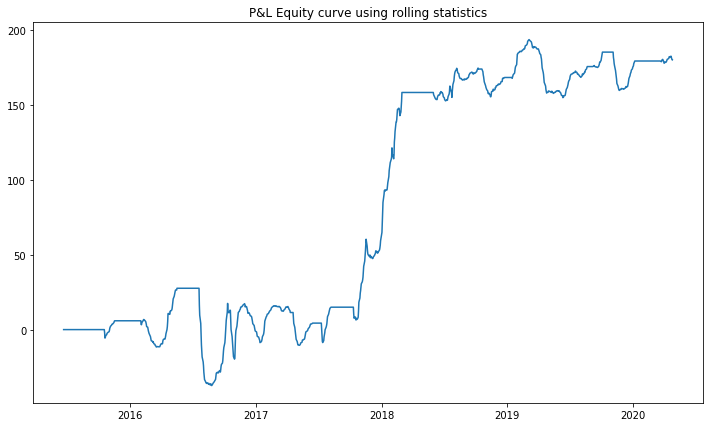

In [ ]:
rolling_pnl=positions(Z_score_rolling, 2, rolling_returns)
plt.figure(figsize=(12,7))
plt.plot(rolling_pnl)
plt.title('P&L Equity curve using rolling statistics')

In [ ]:
def Moving_Z_Scores_backtest(A, B, win, ticker, delta):
  '''
  This function backtests the rolling strategy given any two stocks, the window size and the ticker of stock A.
  It combines all the steps we have taken above into one function.
  '''
  A=sm.add_constant(A)
  rols=RollingOLS(B, A, window=win).fit() # Using a window of windowsize days to calculate beta
  params=rols.params[ticker]
  params.dropna(inplace=True)
  spread_rolling=B-(params*A[ticker])
  spread_rolling.dropna(inplace=True)
  avg_spread=spread_rolling.rolling(window=win).mean()
  avg_std=spread_rolling.rolling(window=win).std()
  avg_spread.dropna(inplace=True)
  avg_std.dropna(inplace=True)
  spread_rolling=spread_rolling[win-1:]
  Z_score_rolling=(spread_rolling-avg_spread)/avg_std
  plt.figure(figsize=(12,7))
  plt.plot(Z_score_rolling)
  plt.axhline(0.0, color='black')
  plt.axhline(1.0, color='green', linestyle='dashed') # Line to show possible delta we can use and so when we enter trades
  plt.axhline(-1.0, color='blue', linestyle='dashed')
  plt.title('Rolling Z value of spread based on past data')
  print('\n')
  rolling_returns=spread_rolling.diff()
  rolling_returns=rolling_returns.shift(-1)
  rolling_pnl=positions(Z_score_rolling, delta, rolling_returns) 
  plt.figure(figsize=(12,7))
  plt.plot(rolling_pnl)
  plt.title('P&L Equity curves using rolling statistics')
  return rolling_pnl




(456,)


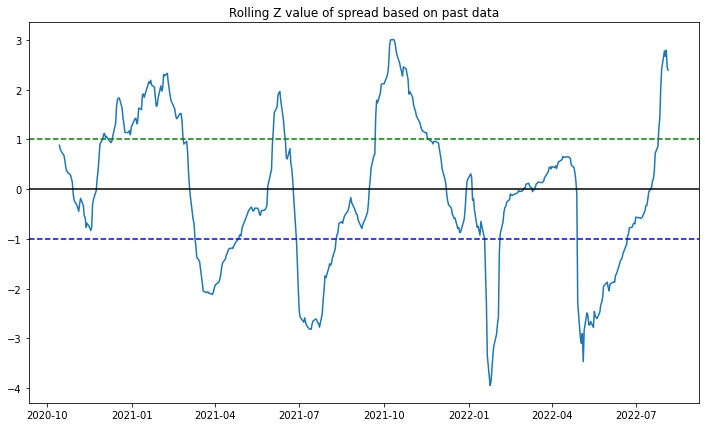

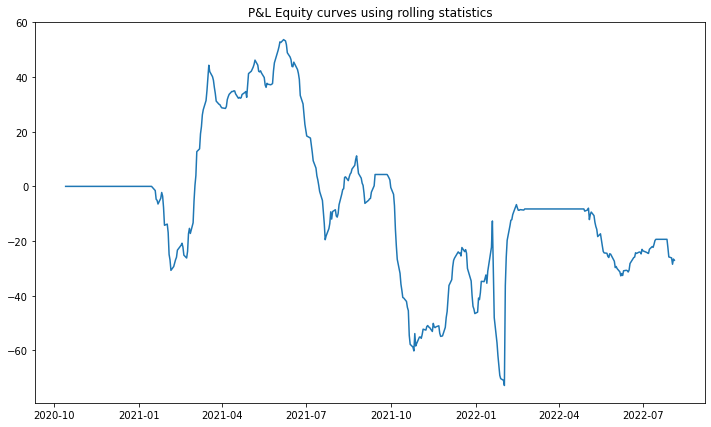

In [ ]:
rolling_pnl_test=Moving_Z_Scores_backtest(A_test, B_test, windowsize, 'META', 2) # Using delta=2

**Results**

We can see that for the test data the strategy did not perform so well. When picking the the pair of stocks we chose them based on cointegration which is a measure of how closely linked the movements of the two stocks are, however we tested for cointegration in the training dataset and it may be that the strength of this cointegration of the stocks is not so strong anymore and as such the strategy does not perform as well. It would be interesting to vary $Δ$ to see the effect this has on the profitability of such strategies.

# Hurst Exponent
Another approach to pairs trading is using the Hurst Exponent to check for the mean reversion of a spread of two securities. We apply it to the same universe of stocks to find mean reverting stock spreads but do not apply a trading strategy, although it can be easily applied. The idea for this comes from paper [2], from which I have extracted a simpler formula to calculate hedge ratio rather than calculating $β$ explicitly using OLS for efficiency.



*   If the Hurtz exponent is less than 0.5 we have evidence to suggest a mean reverting spread.
*   Hurtz exponent around 0.5 suggets a random walk

*   Hurtz exponent greater than 0.5 suggests a trend in the data







In [ ]:
def Hurst_exponent(series):
  '''Estimate for the Hurst Exponent'''
  lags=[i for i in range(2,20)]
  tau=[np.std(np.subtract(series[i:].values, series[:-i].values)) for i in lags]
  poly=np.polyfit(np.log(lags), np.log(tau),1)
  return poly[0]

In [ ]:
Hurst_exponent(train_df['AAPL'])

0.5236811427035628

In [ ]:
a=train_df['AAPL'].pct_change()

In [ ]:
def Hurst_pairs(df):
  S_no=df.shape[1]
  H_exps=np.zeros((S_no,S_no))
  stcks=df.keys()
  for i in range(S_no):
    for j in range(i+1, S_no):
      #print(df[stcks[i]])
      a=df[stcks[i]].pct_change() # For the Hurst Exponent we work in returns due to underlying assumption of geometric Brownian motion
      b=df[stcks[j]].pct_change()
      a=a.fillna(1)
      b=b.fillna(1)
      a[abs(a) < 0.00000001] = np.random.normal(0, 0.00001)
      b[abs(b) < 0.00000001] = np.random.normal(0, 0.00001)
      a=np.log(a)
      b=np.log(b)
      #print(a)
      const=a.std()/b.std() # See paper reference, but reason for this is that our position in stock A has the same vol as position in stock B
      
      pair_series=df[stcks[i]]-const*df[stcks[j]]
      #print(pair_series)
      H_exps[i,j]=Hurst_exponent(pair_series)
  return H_exps

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[[0.         0.46864902 0.44615709 0.42996926 0.45507338 0.52566443
  0.51912454 0.53847005 0.48236984]
 [0.         0.         0.46443534 0.43902275 0.4558898  0.42293374
  0.43497939 0.47678785 0.43207972]
 [0.         0.         0.         0.43841436 0.45426052 0.4395126
  0.50176646 0.45902492 0.48800788]
 [0.         0.         0.         0.         0.44477935 0.43629708
  0.42541352 0.43581003 0.44115812]
 [0.         0.         0.         0.         0.         0.50534502
  0.51085197 0.46230264 0.45553553]
 [0.         0.         0.         0.         0.         0.
  0.5141673  0.50541447 0.44571905]
 [0.         0.         0.         0.         0.         0.
  0.         0.52125032 0.47249591]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.44277441]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


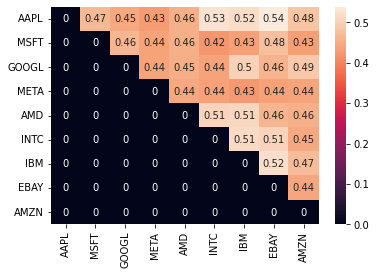

In [ ]:
H_exps=Hurst_pairs(train_df)
print(H_exps)
sns.heatmap(H_exps, xticklabels=stocks, yticklabels=stocks, annot=True)

From the hurst exponent we can see that there are no clear mean reverting spreads, but a useul thing to notice is that there is reasonable crossover between those stocks that scored high for conintegration and the Hurst exponent measure for mean reversion. 

# Further research and areas to improve


*   Pair trading strategies based on a single pair will likely not generate very consistent returns as sort of illustrated by the results above which often show positive returns but seem quite erratic. As such it would be in the portfolio holders benefit to hold a portfolio consisting of many such pairs and this functionality is something that would be interesting to add to the model.
*  I have also not explored Hurtz exponents in much detail at all and this would be something interesting to look further into.


*   Testing a variety of different window sizes and $Δ$ for the rolling statistics framework might also be an interesting thing to try although too much attention to this might lead to overfitting






# References

[1] Rad, Hossein, Rand Kwong Yew Low, and Robert Faff. "The profitability of pairs trading strategies: distance, cointegration and copula methods." Quantitative Finance 16.10 (2016): 1541-1558.

[2] Ramos-Requena, José Pedro, J. E. Trinidad-Segovia, and M. A. Sánchez-Granero. "Introducing Hurst exponent in pair trading." Physica A: statistical mechanics and its applications 488 (2017): 39-45.

[3] Quantopian. "Basic Statistical Arbitrage: Understanding the Math Behind Pairs Trading" by Max Margenot." [Video]. YouTube. https://www.youtube.com/watch?v=g-qvFjvyqcs.